<a href="https://colab.research.google.com/github/ArunK-ML/Project---Shopper-Spectrum-Customer-Segmentation-and-Product-Recommendations-in-E-Commerce/blob/main/Shopper_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🛒 Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce**

# **Step 1:Dataset Collection and understanding**

In [1]:
import pandas as pd
df = pd.read_csv('/content/online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.shape

(398517, 8)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398517 entries, 0 to 398516
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    398517 non-null  object 
 1   StockCode    398517 non-null  object 
 2   Description  397187 non-null  object 
 3   Quantity     398517 non-null  int64  
 4   InvoiceDate  398517 non-null  object 
 5   UnitPrice    398517 non-null  float64
 6   CustomerID   296110 non-null  float64
 7   Country      398516 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


In [8]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [5]:
df.duplicated().sum()

np.int64(3202)

# **Step 2: 📌 Data Preprocessing:**

**Handle Null Value**

In [7]:
df = df.dropna(subset=["CustomerID","Country"])

df["Description"] = df["Description"].fillna("No Description")

**Exclude cancelled invoices (InvoiceNo starting with 'C')**

In [9]:
# Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

**Remove negative or zero quantities and prices**

In [10]:
# Keep only rows where Quantity > 0 and UnitPrice > 0
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

**DateTime DataType Conversation**

In [13]:
# Parse invoice date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Split into Date and Time
df["InvoiceDay"] = df["InvoiceDate"].dt.date
df["InvoiceTime"] = df["InvoiceDate"].dt.time


# **Feature Engineering**

In [22]:
# Add revenue column
df["Total_Amount"] = df["Quantity"] * df["UnitPrice"]

# Reference date = 1 day after last transaction in dataset
ref_date = df["InvoiceDate"].max() + timedelta(days=1)

# ==============================
# 📌 RFM Feature Engineering
# ==============================
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (ref_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Total_Amount", "sum")
).reset_index()

# Merge RFM values into the main transaction dataset
df = df.merge(rfm, on="CustomerID", how="left")

# **Step 3 :📌 Exploratory Data Analysis (EDA):**

In [23]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceTime,Total_Amount,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30,316,34,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,316,34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00,316,34,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,316,34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,316,34,5391.21


In [15]:
df.shape

(288997, 10)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta



📌 Transaction volume by country (unique invoices):
Country
United Kingdom    12630
Germany             343
France              294
EIRE                195
Belgium              77
Spain                67
Netherlands          66
Australia            51
Switzerland          42
Portugal             39
Name: InvoiceNo, dtype: int64


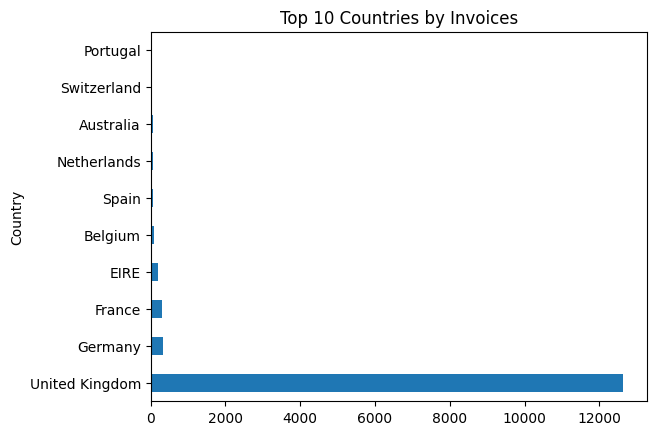

In [17]:
# -----------------------------
# 1) Transaction volume by country
# -----------------------------
tx_by_country = (
    df.groupby("Country")["InvoiceNo"]
      .nunique()
      .sort_values(ascending=False)
)
print("\n📌 Transaction volume by country (unique invoices):")
print(tx_by_country.head(10))

tx_by_country.head(10).plot(kind="barh", title="Top 10 Countries by Invoices")
plt.show()

In [18]:
# -----------------------------
# 2) Top-selling products
# -----------------------------
# By quantity
prod_qty = (
    df.groupby(["StockCode", "Description"])["Quantity"]
      .sum()
      .sort_values(ascending=False)
)
print("\n📌 Top 10 Products by Quantity Sold:")
print(prod_qty.head(10))

# By revenue
prod_rev = (
    df.groupby(["StockCode", "Description"])["Revenue"]
      .sum()
      .sort_values(ascending=False)
)
print("\n📌 Top 10 Products by Revenue:")
print(prod_rev.head(10))


📌 Top 10 Products by Quantity Sold:
StockCode  Description                       
23166      MEDIUM CERAMIC TOP STORAGE JAR        76980
84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS     42043
85099B     JUMBO BAG RED RETROSPOT               37790
85123A     WHITE HANGING HEART T-LIGHT HOLDER    30264
21212      PACK OF 72 RETROSPOT CAKE CASES       29948
84879      ASSORTED COLOUR BIRD ORNAMENT         27176
21977      PACK OF 60 PINK PAISLEY CAKE CASES    22361
22616      PACK OF 12 LONDON TISSUES             21146
15036      ASSORTED COLOURS SILK FAN             20988
22492      MINI PAINT SET VINTAGE                20742
Name: Quantity, dtype: int64


KeyError: 'Column not found: Revenue'

In [ ]:
# -----------------------------
# 3) Purchase trends over time
# -----------------------------
daily = df.set_index("InvoiceDate").resample("D").agg(
    Revenue=("Revenue", "sum"),
    Invoices=("InvoiceNo", "nunique")
)

daily["Revenue"].plot(title="Daily Revenue Over Time")
plt.show()

daily["Invoices"].plot(title="Daily Invoice Counts Over Time")
plt.show()

In [ ]:
# -----------------------------
# 4) Monetary distribution
# -----------------------------
invoice_totals = df.groupby("InvoiceNo")["Revenue"].sum()
customer_totals = df.groupby("CustomerID")["Revenue"].sum()

plt.hist(invoice_totals, bins=50)
plt.title("Distribution of Invoice Totals")
plt.show()

plt.hist(customer_totals, bins=50)
plt.title("Distribution of Customer Totals")
plt.show()


In [ ]:
# -----------------------------
# 5) RFM analysis
# -----------------------------
ref_date = df["InvoiceDate"].max() + timedelta(days=1)

rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (ref_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Revenue", "sum")
).reset_index()

print("\n📌 RFM Sample:")
print(rfm.head())

# Histograms
rfm[["Recency"]].hist(bins=50)
plt.title("Recency Distribution")
plt.show()

rfm[["Frequency"]].hist(bins=50)
plt.title("Frequency Distribution")
plt.show()

rfm[["Monetary"]].hist(bins=50)
plt.title("Monetary Distribution")
plt.show()



In [ ]:
# -----------------------------
# 6) Elbow curve for KMeans clustering
# -----------------------------
X = rfm[["Recency", "Frequency", "Monetary"]]
X_scaled = StandardScaler().fit_transform(X)

inertias = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 11), inertias, marker="o")
plt.title("Elbow Curve (RFM Clustering)")
plt.xlabel("Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Choose k=4 as example
km_final = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = km_final.fit_predict(X_scaled)

print("\n📌 Customer Cluster Profiles:")
print(rfm.groupby("Cluster").mean())

In [ ]:
# -----------------------------
# 7) Product recommendation heatmap
# -----------------------------
# Pick top N products
topN = 30
top_prod_codes = (
    df.groupby("StockCode")["InvoiceNo"]
      .nunique()
      .sort_values(ascending=False)
      .head(topN)
      .index
)

df_top = df[df["StockCode"].isin(top_prod_codes)]
cust_prod = (
    df_top.assign(Buy=1)
          .pivot_table(index="CustomerID", columns="StockCode", values="Buy", aggfunc="max", fill_value=0)
)

sim_matrix = pd.DataFrame(
    cosine_similarity(cust_prod.T),
    index=cust_prod.columns,
    columns=cust_prod.columns
)

plt.imshow(sim_matrix, cmap="viridis")
plt.xticks(range(len(sim_matrix.columns)), sim_matrix.columns, rotation=90)
plt.yticks(range(len(sim_matrix.index)), sim_matrix.index)
plt.title("Product Similarity Heatmap (Top 30 Products)")
plt.colorbar()
plt.show()
